Output()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
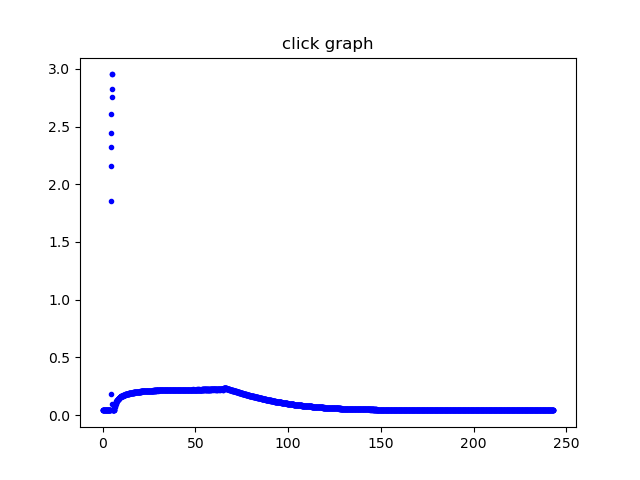

In [1]:
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
from ipywidgets import Output
import glob

file = "時系列/csv/20220909 5HB/30/30 0 490.csv"
data = pd.read_csv(file)
df_data = data.drop(["old_name", "new_name"], axis=1)

file_name = file.split("/")[-1].split(".")[0]
result_dir = "result/" + "/".join(file.split("csv")[1].split("/")[1:-1]) + "/"

df_data = df_data.rename(
    columns={"time " + file_name: "time", "abs " + file_name: "abs"}
)

x = df_data["time"]
y = df_data["abs"]

data_list = []
point_list = []
mask = np.ones(len(x), dtype=bool)
mask[0 : len(x)] = False
# グラフの描画
fig, ax = plt.subplots()
ax.plot(x, y, ".", color="blue", zorder=1)
ax.set_title("click graph")


state = 0
lpoint = 0
rpoint = 0

out = Output()
display(out)

@out.capture(clear_output=True)
def oncpaint(event):
    global state
    global lpoint, rpoint
    ind = np.searchsorted(x, event.xdata)
    # 開始点
    if event.button == 3 and state == 0:
        plt.title("Start point is " + str(ind))
        ax.plot([x[ind]], [y[ind]], ".", color="red", zorder=2)
        fig.canvas.draw()
        value = [event.ydata, event.xdata]
        data_list.append(value)
        state = 1
        lpoint = ind
        print(data_list)
    # 終了点
    elif event.button == 3 and state == 1:
        plt.title("End point is " + str(ind))
        ax.plot([x[ind]], [y[ind]], ".", color="red", zorder=2)
        fig.canvas.draw()
        state = 2
        rpoint = ind + 1
        ax.plot(x[lpoint:rpoint], y[lpoint:rpoint], ".", color="red")
        print(lpoint)
    # キャンセル
    elif event.button == 3 and state == 2:
        plt.title("Canceled")
        state = 0
        ax.plot(x[lpoint:rpoint], y[lpoint:rpoint], ".", color="blue")
    # 決定
    elif event.button == 1 and state == 2:
        plt.title("Approved")
        mask[lpoint:rpoint] = True
        state = 0
        point_list.append([lpoint, rpoint])
        print(lpoint, rpoint)
    # 終了
    elif event.key == "q":
        fig.canvas.mpl_disconnect(cid)


cid = fig.canvas.mpl_connect("button_press_event", oncpaint)
plt.show()

In [2]:
# 選んだ部分をCSVファイルに書き出す
df_list = []
for n in range(len(point_list)):
    dfn = df_data[point_list[n][0] : point_list[n][1]]

    dfn.reset_index(inplace=True)
    dfn = dfn.drop(["index"], axis=1)
    df_list.append(dfn)


df_result = pd.concat(df_list, axis=1)

# df_resultの保存 まだノーマライズしてないデータを保存する
os.makedirs(result_dir, exist_ok=True)
df_result.to_csv(result_dir + file_name + ".csv", index=False)

# normalized curve

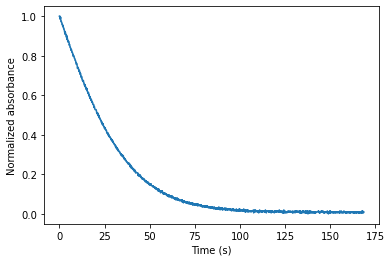

In [3]:
from scipy.optimize import curve_fit
import seaborn as sns
%matplotlib inline


x = df_result['time'] - df_result['time'][0]
y = (df_result['abs'] - min(df_result['abs'])) / (max(df_result['abs']) - min(df_result['abs']))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized absorbance')

ax.plot(x, y)

# 非線形回帰

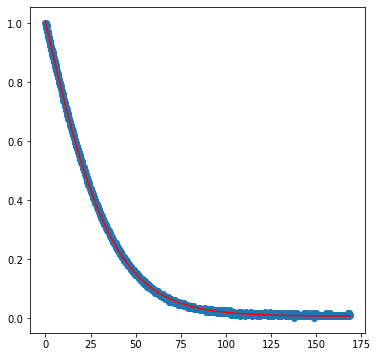

In [5]:
# 参考　https://kunassy.com/python-curve_fit/


%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
from ipywidgets import Output
from scipy.optimize import curve_fit
import seaborn as sns
%matplotlib inline

# TODO Aは定数にしたい

def kinetic_model_f1(x, B, C, D):
    A = 1
    return A*(1-((1-np.exp(D*x))/(1-C*np.exp(D*x)))) + B

# df_result = pd.read_csv("result/20220315/S-Br2/30/480 001.csv")
x = df_result['time'] - df_result['time'][0]
y = (df_result['abs'] - min(df_result['abs'])) / (max(df_result['abs']) - min(df_result['abs']))

data_kinetic_model_f1 = np.array([x, y])

param_init_dict = {
        "data_kinetic_model_f1":[0, 0.6, -0.01]
        }
# グラフ描画用のサンプルデータ
sample_x = np.array(x)


def fit(func, x, param_init):
    """
    func:データxに近似したい任意の関数
    x:データ
    param_init:パラメータの初期値
    popｔ:最適化されたパラメータ
    pocv:パラメータの共分散
    """
    X = x[0]
    Y = x[1]
    popt,pocv=curve_fit(func, X, Y, p0=param_init)
    perr = np.sqrt(np.diag(pocv)) #対角成分が各パラメータの標準誤差に相当
    y=func(sample_x, *popt)
    return y, popt, perr


fit_result = fit(kinetic_model_f1, data_kinetic_model_f1, param_init_dict["data_kinetic_model_f1"])
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(data_kinetic_model_f1[0], data_kinetic_model_f1[1])
ax.plot(sample_x, fit_result[0], color="red")

In [6]:
opt_B = fit_result[1][0]
opt_C = fit_result[1][1]
opt_D = fit_result[1][2]

k_1 = -opt_D
k_2 = -(opt_C * opt_D)/(1 - opt_C)

column_name = file_name

# 測定条件の入力を詳細に行いたい場合
# temp = 30
# wavelength = 490
# filter_combination_list = ["001", "010", "011", "100", "101", "110"]
# period_3 = 25
# filter_combination = filter_combination_list[1]

# if 'period_3' in locals():
#     column_name = str(temp) + " " + str(period_3) + " " + str(wavelength) + " " + filter_combination
# else:
#     column_name = str(temp) + " " + str(wavelength) + " " + filter_combination
    
opt_columns = ["opt_B", "opt_C", "opt_D", "k_1", "k_2"]
opt_params = np.array([opt_B, opt_C, opt_D, k_1, k_2])

df_opt_params = pd.DataFrame(opt_params, index=opt_columns, columns=[column_name])

df_opt_params

,30 0 490
opt_B,0.006083
opt_C,-0.837873
opt_D,-0.049444
k_1,0.049444
k_2,-0.022541


In [7]:
# fit_resultフォルダに保存し、最後に結合したCSVを出力
fit_result_dir = result_dir + "fit_result/"
os.makedirs(fit_result_dir, exist_ok=True)
df_opt_params.to_csv(fit_result_dir + column_name + ".csv", index=True)

# ファイルの結合

In [8]:
# fit_resultフォルダに保存されたcsvファイルの結合、保存
import glob
import codecs

df_opt_params_all = pd.DataFrame()
data_dir = fit_result_dir + "*.csv"
# 手動
# data_dir = ""
paths = [p for p in glob.glob(data_dir)]

for path in paths:
    with codecs.open(path, "r", "UTF-8", "ignore") as file:
        df = pd.read_csv(file)
        df = df.rename(
            columns={df.columns[0]: "params"}
        )
        df = df.set_index("params")
        df_opt_params_all = pd.concat([df_opt_params_all, df], axis=1)

# 保存
os.makedirs(fit_result_dir + "concat", exist_ok=True)
df_opt_params_all.to_csv(fit_result_dir + "concat/df_opt_params_all.csv", index=True)